## Análisis de la metodología para la verificación y construcción de series históricas para el cálculo de la ENFICC en plantas solares fotovoltaicas.

In [1]:
import os
import pandas as pd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Se leen todos los archivos de data: (despuess)

In [2]:
base_dir = os.path.join( '.','data')
output_dir = os.path.join( '.','output')
ciudad = 'Valledupar'
fuente = 'IDEAM'
serie_csv = os.path.join(base_dir,ciudad,fuente+'.csv')
serie_ideam = pd.read_csv(serie_csv, sep = ';',
                encoding='latin-1')


In [3]:
base_dir = os.path.join( '.','data')
output_dir = os.path.join( '.','output')
ciudad = 'Valledupar'
fuente = 'NREL'
serie_csv = os.path.join(base_dir,ciudad,fuente+'.csv')
serie_nrel = pd.read_csv(serie_csv, sep = ';',
                encoding='latin-1')


Función MCP

In [44]:
def mcp(serieReal, serieSatelite):

    mediaY = serieReal["IDEAM"].mean()
    mediaX = serieSatelite["NREL"].mean()
    desvY = serieReal["IDEAM"].std(ddof = 0)
    desvX = serieSatelite["NREL"].std(ddof = 0)
    
    serieAjustada = pd.DataFrame((mediaY-((desvY/desvX)*mediaX)) + ((desvY/desvX)*serieSatelite['NREL']))
    serieAjustada[serieAjustada<0]=0
    serie_ajustada = serieSatelite.copy()
    
    
    del serie_ajustada['NREL']  
   
    serie_ajustada['GHIdiario'] = serieAjustada
        
       
    return serie_ajustada

In [45]:
agno = 2006
mes = 3

serie_corta_IDEAM = serie_ideam[(serie_ideam['AÑO'] == agno) &
                 (serie_ideam['MES'] <= mes)]

serie_corta_NREL  = serie_nrel[(serie_nrel['AÑO'] == agno) &
                 (serie_nrel['MES'] <= mes)]



In [46]:
ajuste = mcp(serie_corta_IDEAM, serie_nrel)


In [47]:
def energia(serie_ener):
    
    def ghi_mensual(serie_horaria):
        agnos = sorted(serie_horaria['AÑO'].unique())
        ghi_df = pd.DataFrame(columns=["AÑO", "MES", "DIAS", "GHImes"])
        for agno in range(2006,2016):
            for mes in range(1,13):
                nombre_energia = list(serie_horaria)[-1]
                dias = sorted(serie_horaria[(serie_horaria['AÑO'] == agno) &
                            (serie_horaria['MES'] == mes)]["DIA"].unique())
                ghi_mes = serie_horaria.loc[((serie_horaria["AÑO"] == agno)
                                & (serie_horaria["MES"] == mes)),
                                            nombre_energia].sum()/1000
                ghi_dict = {"AÑO":agno, "MES":mes, "DIAS":dias[-1],
                            "GHImes":ghi_mes}
                ghi_df = ghi_df.append(ghi_dict, ignore_index=True)
        return ghi_df

    def ghi_dia(serie_ghi_mensual):
        agnos = sorted(serie_ghi_mensual['AÑO'].unique())
        ghi_df = pd.DataFrame(columns=["AÑO", "MES", "GHIdiario"])
        for agno in range(2006,2016):
            for mes in range(1,13):
                dias = serie_ghi_mensual.loc[((serie_ghi_mensual["AÑO"] == agno)
                                & (serie_ghi_mensual["MES"] == mes))
                                             ,"DIAS"].item()
                ghi_diario = serie_ghi_mensual.loc[(
                    (serie_ghi_mensual["AÑO"] == agno)
                                & (serie_ghi_mensual["MES"] == mes)),
                    "GHImes"].item()/dias
                ghi_dict = {"AÑO":agno, "MES":mes, "GHIdiario":ghi_diario}
                ghi_df = ghi_df.append(ghi_dict, ignore_index=True)
        return ghi_df

    
    ghi_mensual_loc = ghi_mensual(serie_ener)
    ghi_diario_loc = ghi_dia(ghi_mensual_loc)
    serie = sorted(ghi_diario_loc["GHIdiario"])
    numdatos = range(len(serie))
    percentil = 0.01
    enficc = ghi_diario_loc.quantile(q=percentil, 
                                     numeric_only=True)["GHIdiario"]
    print('La ENFICC 99% es: ', enficc)
    
    return serie, enficc, numdatos

In [60]:
def grafica(energia_ideam, energia_nrel, energia_ajustada):
    pylab.xlabel("Datos")
    pylab.ylabel("Energía/Energía Base IDEAM")
    pylab.plot(energia_ideam[2],energia_ideam[0],'-k', label='IDEAM')
    pylab.plot(energia_nrel[2],energia_nrel[0],'-r', label='NREL')
    pylab.plot(energia_ajustada[2],energia_ajustada[0],'-b', label='AJUSTADA')
    pylab.legend(loc='upper left')
    #pylab.savefig(os.path.join(output_dir,'valledupar_IDEAM.png'), dpi=600)
    

In [61]:
ideam = energia(serie_ideam)
nrel = energia(serie_nrel)
ajustada = energia(ajuste)

La ENFICC 99% es:  4.56900737661
La ENFICC 99% es:  5.06672598387
La ENFICC 99% es:  4.86511516673


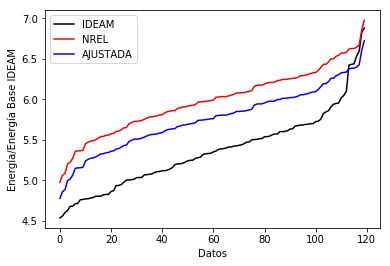

In [62]:
grafica(ideam,nrel,ajustada)